<a href="https://colab.research.google.com/github/sadia-sigma-lab/task-agnostic-data-valuation/blob/main/data_valuation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

labels  [0 1 2 3 4]
seller Seller 1 (Classes 0-4)
labels  [1 2 3 4 5]
seller Seller 2 (Classes 1-5)
labels  [0 1 2 3 4 5 6 7 8 9]
seller Seller 3 (Classes 0-9)
labels  [3 4 5 6 7 8 9]
seller Seller 4 (Classes 3-9)
labels  [5 6 7 8 9]
seller Seller 5 (Classes 5-9)
buyer_eigenvalues [1.76943192e+02 9.91036224e+01 5.60928421e+01 4.15209656e+01
 2.50868683e+01 2.21514606e+01 1.70868587e+01 1.34529266e+01
 1.20916023e+01 1.05052433e+01 9.98393059e+00 8.60867023e+00
 8.03807926e+00 7.61218452e+00 7.33735561e+00 6.92736483e+00
 6.51128817e+00 6.35023880e+00 5.79067755e+00 5.70379639e+00
 5.43475342e+00 5.32658625e+00 4.85942602e+00 4.67801332e+00
 4.49129105e+00 4.37573051e+00 4.22644997e+00 3.90164137e+00
 3.82400846e+00 3.68091488e+00 3.53925920e+00 3.29139566e+00
 3.18084383e+00 3.11155939e+00 2.97305250e+00 2.85405779e+00
 2.75256133e+00 2.75095272e+00 2.73274803e+00 2.59841657e+00
 2.53749347e+00 2.48084879e+00 2.38457704e+00 2.25743103e+00
 2.22309899e+00 2.20116448e+00 2.15300560e+00 2

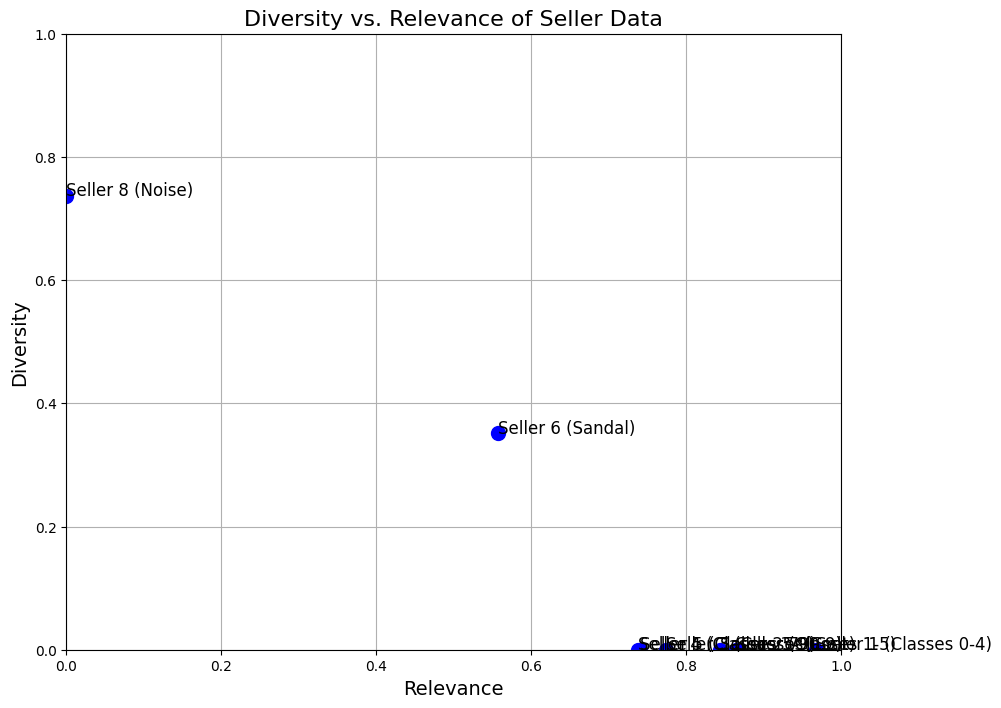

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tensorflow.keras.datasets import mnist, fashion_mnist


np.random.seed(42)
def preprocess_images(images, epsilon=1e-11):
    images = images.reshape(len(images), -1)  # Flatten the images
    images = images.astype('float32') / 255.0  # Normalize pixel values to [0,1]
    mean = np.mean(images, axis=0)
    std_dev = np.std(images, axis=0)

    # Avoid division by zero by adding a small epsilon to std_dev
    images = (images - mean) / (std_dev + epsilon)  # Zero-center and normalize
    return images

# Function to get data for buyer or sellers
def get_data(images, labels, classes, exclude_indices=set(), num_samples=10000):
    indices = np.where(np.isin(labels, classes))[0]
    # Exclude already used indices to ensure distinct images
    indices = np.setdiff1d(indices, list(exclude_indices))
    np.random.shuffle(indices)
    selected_indices = indices[:num_samples]
    selected_images = images[selected_indices]
    selected_labels = labels[selected_indices]
    return selected_images, selected_labels, set(selected_indices)

# Function to compute projected eigenvalues
def compute_projected_eigenvalues(data, components, num_components):
    projected_data = np.dot(data, components.T)
    covariance_matrix = np.cov(projected_data, rowvar=False)
    eigenvalues = np.linalg.eigvalsh(covariance_matrix)
    eigenvalues = np.flip(np.sort(eigenvalues))[:num_components]
    return eigenvalues


# Function to compute diversity and relevance
def compute_diversity_relevance(buyer_eigenvalues, seller_eigenvalues):
    max_vals = np.maximum(buyer_eigenvalues, seller_eigenvalues)
    min_vals = np.minimum(buyer_eigenvalues, seller_eigenvalues)
    abs_diff = np.abs(buyer_eigenvalues - seller_eigenvalues)

    # Handle division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        diversity_components = abs_diff / max_vals
        relevance_components = min_vals / max_vals

    # Replace NaN values with zero
    valid_mask = ~np.isnan(diversity_components) & ~np.isnan(relevance_components)

# Apply the mask to filter out rows containing NaN in either array
    diversity_components = diversity_components[valid_mask]
    relevance_components = relevance_components[valid_mask]
    if np.any(diversity_components == 0):
      print("Zero values found in diversity_components at indices:", np.where(diversity_components == 0))

    if np.any(relevance_components == 0):
      print("Zero values found in relevance_components at indices:", np.where(relevance_components == 0))
    # diversity_components = np.nan_to_num(diversity_components)
    # relevance_components = np.nan_to_num(relevance_components)

    diversity = np.prod(diversity_components)
    print("diver prod" , diversity)
    diversity = diversity ** (1 / len(diversity_components))
    relevance = np.prod(relevance_components)
    print("relevancy prod" , relevance)
    relevance =relevance ** (1 / len(relevance_components))
    return diversity, relevance


# Load fashion-MNIST dataset
(fmnist_train_images, fmnist_train_labels), (fmnist_test_images, fmnist_test_labels) = fashion_mnist.load_data()
fmnist_images = np.concatenate((fmnist_train_images, fmnist_test_images))
fmnist_labels = np.concatenate((fmnist_train_labels, fmnist_test_labels))

# Prepare Buyer's Data
buyer_classes = [0, 1, 2, 3, 4]
buyer_images, buyer_labels, buyer_indices = get_data(
    fmnist_images, fmnist_labels, buyer_classes, num_samples=6000)

used_indices = buyer_indices.copy()  # Keep track of used indices to ensure distinct datasets

# Prepare Sellers' Data
sellers_info = [
    ("Seller 1 (Classes 0-4)", [0, 1, 2, 3, 4]),
    ("Seller 2 (Classes 1-5)", [1, 2, 3, 4, 5]),
    ("Seller 3 (Classes 0-9)", list(range(0, 10))),
    ("Seller 4 (Classes 3-9)", [3, 4, 5, 6, 7, 8, 9]),
    ("Seller 5 (Classes 5-9)", [5, 6, 7, 8, 9])
]

seller_images_list = []
seller_labels_list = []
seller_names = []
for name, classes in sellers_info:
    images, labels, indices = get_data(
        fmnist_images, fmnist_labels, classes, exclude_indices=used_indices, num_samples=10000)
        # fmnist_images, fmnist_labels, classes,  num_samples=10000)
    used_indices.update(indices)
    seller_images_list.append(images)
    seller_labels_list.append(labels)
    unique_labels = np.unique(labels)
    print("labels " , unique_labels)
    print("seller" , name)
    seller_names.append(name)

# Sellers from fashion-MNIST
# Seller 6: Sandal (Class 5)
seller6_indices = np.where(fmnist_labels == 5)[0]
np.random.shuffle(seller6_indices)
seller6_images = fmnist_images[seller6_indices[:10000]]
seller6_labels = fmnist_labels[seller6_indices[:10000]]
seller_images_list.append(seller6_images)
seller_labels_list.append(seller6_labels)
seller_names.append("Seller 6 (Sandal)")

# Seller 7: Coat (Class 4)
seller7_indices = np.where(fmnist_labels == 4)[0]
np.random.shuffle(seller7_indices)
seller7_images = fmnist_images[seller7_indices[:10000]]
seller7_labels = fmnist_labels[seller7_indices[:10000]]
seller_images_list.append(seller7_images)
seller_labels_list.append(seller7_labels)
seller_names.append("Seller 7 (Coat)")

# Seller 8: Noisy images
seller8_images = np.random.normal(0, 1, (1000, 28, 28))
seller8_labels = None  # No labels
seller_images_list.append(seller8_images)
seller_labels_list.append(seller8_labels)
seller_names.append("Seller 8 (Noise)")

# Preprocess Buyer's Data
buyer_data = preprocess_images(buyer_images)

# Perform PCA on Buyer's Data
pca = PCA()
pca.fit(buyer_data)
buyer_eigenvalues = pca.explained_variance_
buyer_components = pca.components_

# Select principal components with eigenvalues > 1e-2
print("buyer_eigenvalues" , buyer_eigenvalues)
significant_components = buyer_eigenvalues > 1e-2
print('significant_components', significant_components)
buyer_eigenvalues = buyer_eigenvalues[significant_components]
buyer_components = buyer_components[significant_components]

# Compute Diversity and Relevance for Each Seller
diversity_vals = []
relevance_vals = []

for idx, seller_images in enumerate(seller_images_list):
    # Preprocess Seller's Data
    seller_data = preprocess_images(seller_images)
    # Compute Seller's Projected Eigenvalues
    seller_eigenvalues = compute_projected_eigenvalues(
        seller_data, buyer_components, len(buyer_eigenvalues))
    # Compute Diversity and Relevance
    diversity, relevance = compute_diversity_relevance(buyer_eigenvalues, seller_eigenvalues)
    diversity_vals.append(diversity)
    relevance_vals.append(relevance)

# Plot Diversity vs. Relevance
plt.figure(figsize=(10, 8))
plt.scatter(relevance_vals, diversity_vals, color='blue', s=100)
for i, txt in enumerate(seller_names):
    print("seller name" , txt )
    print("relevance_vals[i]" , relevance_vals[i] )
    print("diversity_vals[i" , diversity_vals[i] )
    plt.annotate(txt, (relevance_vals[i], diversity_vals[i]), fontsize=12)
plt.title("Diversity vs. Relevance of Seller Data", fontsize=16)
plt.xlabel("Relevance", fontsize=14)
plt.ylabel("Diversity", fontsize=14)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.show()


In [2]:
fmnist_images.shape


(70000, 28, 28)